# Carry Factor for Commodity Futures

## Reference Article

I choose one article in zhihu, one popular Chinese website where people can ask questions and connect with people who contribute unique insights: \
**如何构建稳健的商品期货carry组合？**: https://zhuanlan.zhihu.com/p/46197447

## Carry Factor

Carry factor is a very useful but simple one for commodity futures.  As we all know, there are several contracts with different maturity date for every kind of commodity futures. For example, in March 1st, 2021, there are IF2103, IF2104, IF2106, IF2106 for IF. However, although they are all IFs, but these contracts have different prices due to their different maturity dates, which is the reason why the carry factor is useful.

Normally, we define carry factor as (S-F)/(F*t2), where S is the price of the spot and F is the price of futures, t2 is the time between now and the maturity date of the futures. But this formula is just a theoretical one, since normally we cannot get the price of the spot.  As a consequence, we find different ways to compute the value of the carry factor:

1. the first way is to select two contracts for one kind of futures.  In this case, we have three choices obviously:

   a. main contract and sub main contract (the near contract as S, the far contract as F)

   b. near contract and sub near contract

   c. main contract and near contract(the nearest contract except the main contract)

2. the slope of y (the natrual logarithm of the price of different contracts) and x(the natural dates between the maturity dates of different contracts and the maturity date of the nearest contract).

# Construction of the backtesting framework

The backtesting framework is composed of the following parts:

1. bases
2. factor
3. commodity pool
4. signals
5. weight
6. backtesting
7. factor_test

# bases

As we all know,  factors, commodity pools, signals, weight, backtesting are all with params. One question we need to tackle is to deal with senarios with many different params. I learn a very sueful way from the way of managing params of BaseEstimator in sklearn. we can make as keywrod argument of the contruction method of every class involving params. For further reference, please visit the website:  
https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

For example, if we have a factor named A with params R=5, H=10, then we just need to instantiate:

In [5]:
from bases.base import BaseClass

class A(BaseClass):
    def __init__(self, R: int, H: int = 10) -> None:
        super().__init__(R=R, H=H)

In [6]:
a = A(R=5, H=10)

In [7]:
a.get_params()

{'H': 10, 'R': 5}

In [8]:
a.set_params(R=20, H=5)
a.get_params()

{'H': 5, 'R': 20}

From the example above, we can know that one class inheriting from BaseClass can have several parameters. Once an instance of this class is instantiated, we need to specify the parameters. Besides, we can use the method **get_params** to get the parameters and we can also use the method **set_params** to set or change the parameters.


**In my framework, factor class, signal class, weight class and backtesting class are all inherited from BaseClass.** As a consequence, we apply this method of managine parameters in the same way.

# factor

## factor group and name

In the factor package, I define a class named BaseFactor, which is the base class of all factors. And every factor has its own group and name. Sometimes, we may also define a base class for every factor group. For example, every carry factor is inherited from the BaseCarryFactor, while the BaseCarryFactor is inherited from the BaseCalss.

For example, in the factor package, there is one folder named CarryFactor and in the folder there are several .py file such as FarNearFactor.py, MainNearFactor1.py, MainNearFactor2.py, etc. And in every .py file, there is one class with the same name as the .py file, which is how the factor is defined. For the MainNearFactor3, its group is CarryFactor and its name is MainNearFactor3. For the factor MainNearFactor3, it is a kind of CarryFactor and its name is MainNearFactor3.

## How to define a new factor

To define a new factor, we need to specfy its group and name. If it is included in a new group, you can create a new python package in the factor package. Otherwise, the .py file of the new factor can be in an existing python package, which means it is in this group.

### common method: compute_factor

The method compute_factor is an abstractmethod in the BaseClass. Therefore, every factor must redefine this method. This method is the place where we define how to compute the factor.

The following is the source code of MainNearFactor3.

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas import DataFrame

from factor.CarryFactor.base import BaseCarryFactor
from utils.utility import stack_dataframe_by_fields
from factor.contract_utility import get_near_contract_except_main

class MainNearFactor3(BaseCarryFactor):
    """
    利用主力合约和去除主力合约后最近合约计算的期限结构因子

    合约: 主力合约和去除主力合约后最近合约，两者中近的合约定义为近月合约，远的合约定义为远月合约. 若合约只有一个，则因子值为缺失值

    时间差: 月份差

    计算方法: (近月合约价格-远月合约价格)/(远月合约价格*时间差)

    Attributes
    __________
    price: str
            用于代表合约价格的字段, close或settlement

    window: int
            因子平滑参数，所有因子都具有

    See Also
    ________
    factor.CarryFactor.bases.BaseFactor
    """

    def __init__(self, price: str = 'close', window: int = 1):
        """
        Constructor

        Parameters
        ----------
        price: str
                用于代表合约价格的字段，close或settlement

        window: int
                因子平滑参数，所有因子都具有
        """
        super().__init__(price=price, window=window)

    def compute_single_factor(self, symbol: str) -> DataFrame:
        """
        计算单品种的因子值

        Parameters
        ----------
        symbol: str
                品种代码

        Returns
        -------
        因子值: DataFrame
                默认的index, 三列, datetime, underlying_symbol(均为symbol), factor
        """
        params = self.get_params()
        price = params['price']
        main_contract_df = self.get_continuous_contract_data(symbol=symbol, price=price)
        main_contract_df = main_contract_df[['datetime', 'contract_before_shift']]\
            .rename(columns={'contract_before_shift': 'main_contract'})

        # 获取除主力合约以外的近月合约
        price_df: DataFrame = self.get_field(symbol=symbol, field=price)
        stack_price_df: DataFrame = price_df.stack().to_frame("price").reset_index()
        near_contract_df = get_near_contract_except_main(price_df, main_contract_df)

        # 获取每个合约的到期日
        maturity_date = self.get_maturity_date(symbol)

        # 预先拼接工作
        main_contract_df = pd.merge(left=main_contract_df,
                                    right=maturity_date.rename(columns={'contract': 'main_contract',
                                                                        'maturity_date':
                                                                            'main_contract_maturity_date'}),
                                    on='main_contract', how='left')

        main_contract_df = pd.merge(left=main_contract_df,
                                    right=stack_price_df.rename(
                                        columns={'contract': 'main_contract', 'price': 'main_price'}),
                                    on=['datetime', 'main_contract'], how='left')

        near_contract_df = pd.merge(left=near_contract_df,
                                    right=maturity_date.rename(columns={'contract': 'near_contract',
                                                                        'maturity_date':
                                                                            'near_contract_maturity_date'}),
                                    on='near_contract', how='left')

        near_contract_df = pd.merge(left=near_contract_df,
                                    right=stack_price_df.rename(
                                        columns={'contract': 'near_contract', 'price': 'near_price'}),
                                    on=['datetime', 'near_contract'], how='left')

        # factor: 因子值
        main_near_df = pd.concat([main_contract_df.set_index('datetime'), near_contract_df.set_index('datetime')],
                                 axis=1).reset_index()
        main_near_df.index = range(len(main_near_df))
        # 远月合约价格
        main_near_df['far_price'] = pd.Series(np.where(main_near_df['main_contract'] > main_near_df['near_contract'],
                                                       main_near_df['main_price'],
                                                       main_near_df['near_price']))

        main_near_df['near_close'] = pd.Series(np.where(main_near_df['main_contract'] < main_near_df['near_contract'],
                                                        main_near_df['main_price'],
                                                        main_near_df['near_price']))

        main_near_df['far_contract'] = pd.Series(np.where(main_near_df['main_contract'] > main_near_df['near_contract'],
                                                          main_near_df['main_contract'],
                                                          main_near_df['near_contract']))

        main_near_df['near_contract'] = pd.Series(
            np.where(main_near_df['main_contract'] < main_near_df['near_contract'],
                     main_near_df['main_contract'],
                     main_near_df['near_contract']))

        main_near_df['near_maturity_date'] = pd.Series(
            np.where(main_near_df['main_contract_maturity_date'] < main_near_df['near_contract_maturity_date'],
                     main_near_df['main_contract_maturity_date'],
                     main_near_df['near_contract_maturity_date']))

        main_near_df['far_maturity_date'] = pd.Series(
            np.where(main_near_df['main_contract_maturity_date'] > main_near_df['near_contract_maturity_date'],
                     main_near_df['main_contract_maturity_date'],
                     main_near_df['near_contract_maturity_date']))

        # main_near_df['date_delta'] = (main_near_df['near_maturity_date'] -
        #                               main_near_df['far_maturity_date']).dt.days

        main_near_df['far_year_month'] = pd.to_datetime('20' + main_near_df['far_contract'].str[-4:] + '01')
        main_near_df['far_year'] = main_near_df['far_year_month'].dt.year
        main_near_df['far_month'] = main_near_df['far_year_month'].dt.month

        main_near_df['near_year_month'] = pd.to_datetime('20' + main_near_df['near_contract'].str[-4:] + '01')
        main_near_df['near_year'] = main_near_df['near_year_month'].dt.year
        main_near_df['near_month'] = main_near_df['near_year_month'].dt.month

        main_near_df['month_delta'] = -((main_near_df['far_year'] - main_near_df['near_year']) * 12 +
                                        (main_near_df['far_month'] - main_near_df['near_month']))

        main_near_df['factor'] = (main_near_df['near_price'] - main_near_df['far_price']) / (main_near_df['far_price'] *
                                                                                             main_near_df[
                                                                                                 'month_delta'])

        main_near_df = main_near_df[['datetime', 'near_contract', 'far_contract',
                                    'near_price', 'far_price',
                                    'month_delta', 'factor']]

        main_near_df['underlying_symbol'] = symbol
        factor =main_near_df[['datetime', 'underlying_symbol', 'factor']]
        return factor

    def compute_factor(self) -> DataFrame:
        """
        计算因子，通过对compute_single_factor实现

        Returns
        -------
        因子值: DataFrame
                index为datetime, columns为underlying_symbol, data为factor
        """

        symbol_list = self.get_symbol_list()
        factor_list = []
        for symbol in tqdm(symbol_list):
            factor = self.compute_single_factor(symbol)
            factor_list.append(factor)
        factor = pd.concat(factor_list, axis=0)
        factor = stack_dataframe_by_fields(data=factor,
                                           index_field='datetime',
                                           column_field='underlying_symbol',
                                           data_field='factor')
        factor = factor.rolling(window=self.window, min_periods=1).mean()
        self.factor_value = factor
        return factor

## FactorDataManager

FactorDataManager is the class where we can get the factor, save the factor locally.

In [21]:
from data_manager.FactorDataManager import FactorDataManager
self = FactorDataManager()

## The methods and attributes of FactorDataManager
FactorDataManager has the following methods and attributes:

In [22]:
[method for method in dir(self) if not method.startswith("__")]

['check_local_factor_data',
 'compute_factor',
 'factor_data_folder_path',
 'factor_dict',
 'factor_file_folder_path',
 'factor_group_list',
 'get_factor',
 'get_file_name',
 'import_factor_class',
 'init_factor_group_list',
 'save_factor']

## Get a factor 

If the factor value has already been stored locally, this method will load data locally. Otherwise, it will compute the factor value and save it locally so that the user do not need to spend time waiting the computation again. In order to get the full information of the factor, the return of the method **get_factor** will return the factor instance itself.

In [23]:
factor = self.get_factor(group='CarryFactor', name='MainNearFactor3', price='close')

Since the \_\_repr\_\_ method has been redefined again, the user can easily see the basic information of the factor by print the instance itself.

In [24]:
factor

factor(group=CarryFactor, name=MainNearFactor3, price=close, window=1)

### The attributes and methods of a factor

Get the factor value.

In [25]:
factor.factor_value

underlying_symbol,A,AG,AL,AP,AU,B,BB,BC,BU,C,...,TF,TS,UR,V,WH,WR,WT,Y,ZC,ZN
datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-05,-0.018093,NaN,-0.002926,NaN,0.001314,-0.042694,NaN,NaN,NaN,0.018340,...,NaN,NaN,NaN,NaN,0.010199,NaN,0.000000,-0.038462,NaN,-0.003555
2009-01-06,-0.015901,NaN,-0.007438,NaN,-0.004756,-0.035408,NaN,NaN,NaN,0.017197,...,NaN,NaN,NaN,NaN,0.009801,NaN,0.000000,-0.028207,NaN,-0.004711
2009-01-07,-0.010948,NaN,-0.006574,NaN,-0.001460,-0.037962,NaN,NaN,NaN,0.015370,...,NaN,NaN,NaN,NaN,0.008337,NaN,0.004963,-0.023498,NaN,-0.011883
2009-01-08,-0.013158,NaN,-0.007882,NaN,-0.004557,-0.044682,NaN,NaN,NaN,0.015575,...,NaN,NaN,NaN,NaN,0.007583,NaN,0.006484,-0.034365,NaN,-0.013233
2009-01-09,-0.009965,NaN,-0.009544,NaN,-0.002204,-0.038712,NaN,NaN,NaN,0.016624,...,NaN,NaN,NaN,NaN,0.009563,NaN,0.006632,-0.026808,NaN,-0.011866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,0.001099,0.004384,0.000000,0.008941,0.001942,0.014957,0.0,0.0,0.015407,0.006334,...,0.0,0.0,0.008255,-0.004639,0.000000,-0.008814,NaN,-0.017134,0.000000,0.000000
2020-12-17,0.000804,0.003908,0.000000,0.014377,0.001758,0.007893,0.0,0.0,0.015143,0.006984,...,0.0,0.0,0.007174,-0.006861,0.000000,-0.008774,NaN,-0.019160,-0.014135,0.000000
2020-12-18,0.002490,0.004064,0.000000,0.020771,0.001978,0.012164,0.0,0.0,0.014482,0.006692,...,0.0,0.0,0.008034,-0.004820,0.000000,-0.006454,NaN,-0.022668,-0.015479,0.000000


Get the parameters of the factor.

In [26]:
factor.get_params()

{'price': 'close', 'window': 1}

Another way of getting the parameter of the factor is to regard the parameter of the factor instance.

In [27]:
factor.price

'close'

In [28]:
factor.window

1

# commodity_pool

Commodity pool is used to filter commodity futures beferoe we compute the factor and run the backtest. There are many different commodity pools. In this project, I define several commodity pools, such as DynamicPool1, DynamicPool2, DynamicPool3, etc.

## commodity pool group and name

In the commodity pool package, I define a class named BaseCommodityPool, which is the base class of all commodity pools. And every commodity pool has its own group and name. Sometimes, we may also define a base class for every commodity pool group. 

## define a new commodity pool

To define a new commodity pool, you need to create a commodity pool group by creating a new python package in the commodity pool package if this new group does not exists. Then we need to create a .py file in the group package with the same name as the name of the commodity pool. In this .py file, we need to create a new class inheriting from BaseCommodityPool and redefine the method compute_commodity_pool. The following is the example of DynamicPool3.

In [32]:
import numpy as np
from pandas import DataFrame
from commodity_pool.base import BaseCommodityPool

class DynamicPool3(BaseCommodityPool):

    def __init__(self, q: float = 0.25, window: int = 126) -> None:
        super().__init__(q=q, window=window)

    def compute_commodity_pool(self) -> DataFrame:
        daily_data = self.daily_data_manager.get_daily_data()
        daily_open_interest = daily_data.groupby(['datetime', 'underlying_symbol'], as_index=True)[
            'open_interest'].sum(). \
            unstack(level=-1)
        daily_rolling_open_interest = daily_open_interest.rolling(window=self.window, min_periods=0).mean()
        daily_rolling_open_interest.loc[:, ['IF', 'IH', 'IC', 'T', 'TF', 'TS', 'SC', 'NR', 'LU', 'BC']] = np.nan
        daily_quantile = daily_rolling_open_interest.quantile(q=self.q, axis=1, interpolation='higher')
        commodity_pool_value = (daily_rolling_open_interest.T >= daily_quantile).T
        commodity_pool_value.fillna(False, inplace=True)

        self.commodity_pool_value = commodity_pool_value
        return commodity_pool_value

## The definition of the DynamicPool3

First, we exclude IF, IH, IC, T, TF, TS, SC, NR, LU, BC. Then we compute the open interest for every kind of commodity futures(just add the open interest of all contracts for one symbol). Eevery day, we compute the 25% quantile of the open interest of all commodity futures. We put those commodity futures whose open interest is larger than this quantile number in our commodity pool

## CommodityPoolManager

Just like FactorDataManager, commodity pools are also managed by some manager, CommodityPoolManager.

### The method and attributes of CommodityPoolManager

In [30]:
from data_manager.CommodityPoolManager import CommodityPoolManager
self = CommodityPoolManager()

In [31]:
[method for method in dir(self) if not method.startswith("__")]

['commodity_pool_data_folder_path',
 'commodity_pool_dict',
 'commodity_pool_file_folder_path',
 'compute_commodity_pool',
 'get_commodity_pool',
 'get_commodity_pool_in_out',
 'get_commodity_pool_time_series_plot',
 'get_file_name',
 'import_commodity_pool_class',
 'save_commodity_pool']

## Get a commodity pool

If the commodity pool value has already been stored locally, this method will load data locally. Otherwise, it will compute the commodity pool value and save it locally so that the user do not need to spend time waiting the computation again. In order to get the full information of the commodity pool, the return of the method **get_commodity_pool** will return the commodity pool instance itself.

In [34]:
dynamic_pool3 = self.get_commodity_pool(group='DynamicPool', name='DynamicPool3')

In [35]:
dynamic_pool3.commodity_pool_value
# True means that the symbol is in the commodity pool on that day.

underlying_symbol,A,AG,AL,AP,AU,B,BB,BC,BU,C,...,TF,TS,UR,V,WH,WR,WT,Y,ZC,ZN
datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-05,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
2009-01-06,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
2009-01-07,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
2009-01-08,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
2009-01-09,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,True,True,True,True,True,False,False,False,True,True,...,False,False,True,True,False,False,False,True,True,True
2021-02-23,True,True,True,True,True,False,False,False,True,True,...,False,False,True,True,False,False,False,True,True,True
2021-02-24,True,True,True,True,True,False,False,False,True,True,...,False,False,True,True,False,False,False,True,True,True


In [37]:
dynamic_pool3.get_params()

{'q': 0.25, 'window': 126}

In [38]:
dynamic_pool3.q

0.25

In [39]:
dynamic_pool3.window

126

# signals

The signals package is to transform factor into signal(long=1.0, short=-1.0, no position=0.0) combined with commodity pool. The detailed process is to filter some symbols according to the commodity pool and then filter symbols according to the signal. Finally, we can get a dataframe with the same shape as the factor value.

Three are four types of signals, which are CompositeSignal, CrossSectionSignal, TimeSeriesSignal and GroupSignal. CrossSectionSignal is used in cross sectional strategies, which focus on the rank of different symbols. Other signals can be also known from their names.

## define a new signal

Defining a new signal is very similar to defining a factor or a commodity pool. You need to specify the group first and then create .py file with the same name as the name of this signal. Besides, you need to redefine the trasnform method.

In [40]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from signals.CrossSectionSignal.base import BaseCrossSectionSignal

class CrossSectionSignal1(BaseCrossSectionSignal):
    """
    横截面信号生成器1

    因子值大于quantile(quantile>0.5)分位数的品种做多, 因子值小于1-quantile分位数的品种做空

    Attributes
    __________
    quantile: float, default 0.75
                分位数, 0.5 < quantile < 1.0

    rank: str, default descending
            排序方法, descending表示因子值大的品种做多, ascending表示因子值小的品种做多

    """
    def __init__(self, quantile: float = 0.75, rank: str = 'descending') -> None:
        """Constructor"""
        super().__init__(quantile=quantile, rank=rank)

    def transform(self) -> DataFrame:
        """
        生成信号, 1表示做多, -1表示做空,
        Returns
        -------
        signal_df: DataFrame
                    信号DataFrame, index为交易时间, columns为品种代码, data为信号值-
        """
        if not isinstance(self.factor_data, DataFrame):
            raise ValueError("Please specify the factor_data first!")
        else:
            factor_data = self.factor_data

        if not isinstance(self.commodity_pool, DataFrame):
            raise ValueError("Please specify the commodity pool first!")
        else:
            commodity_pool = self.commodity_pool

        factor_data[~commodity_pool] = np.nan

        params = self.get_params()
        rank = params['rank']
        quantile = params['quantile']

        if rank == 'ascending':
            factor_data = - factor_data

        def apply_quantile(series):
            quantile1 = series.quantile(q=quantile, interpolation='midpoint')
            quantile2 = series.quantile(q=1-quantile, interpolation='midpoint')
            signal_series = pd.Series(data=0.0, index=series.index)
            signal_series[series >= quantile1] = 1.0
            signal_series[series <= quantile2] = -1.0
            return signal_series

        signal_df = factor_data.apply(func=apply_quantile, axis=1)
        self.signal_df = signal_df
        return signal_df

# weight

The weight package is to trasform the signal into weight. Three are many types of weights. Now I have defined two types of weights, EqualWeight and GroupWeight. EqualWeight is very simple, every symbol is with equal weight. GroupWeight is used in group backtesting.

## How to define a new weight

Defining a new weight is also very similar to defining a new signal. First you need to specify the weight group and weight name, and then create a weight class. Besides, we need to redefine the get_weight method.

In [41]:
import numpy as np
from pandas import DataFrame
from weight.base import BaseWeight

class RiskNeutralEqualWeight(BaseWeight):
    """
    等权重生成器
    """
    def __init__(self) -> None:
        """Constructor"""
        super().__init__()

    def get_weight(self) -> DataFrame:
        """
        获取权重DataFrame

        Returns
        -------
        weight_df: DataFrame
                    权重DataFrame
        """

        # 预先检查
        if not isinstance(self.signal_df, DataFrame):
            raise ValueError("Please specify signal_df first!")

        signal_df = self.signal_df
        long_signal_df = signal_df.copy()
        long_signal_df[long_signal_df < 0.0] = 0.0
        long_weight_df = (long_signal_df.T / np.abs(long_signal_df).sum(axis=1)).T / 2
        short_signal_df = signal_df.copy()
        short_signal_df[long_signal_df > 0.0] = 0.0
        short_weight_df = (short_signal_df.T / np.abs(short_signal_df).sum(axis=1)).T / 2
        weight_df = long_weight_df + short_weight_df
        self.weight_df = weight_df
        return weight_df

# backtesting

The backtesting package is the most important part of the the backtesting framework.

## Types of backtesting

There are three types of backtesting. period_backtesting, monthly backtesting and group_backtesting.

### period_backtesting

Period Backtesting means that we define a rebalance period, such as 20 days. We rebalance our portfolio every 20 days. However, these 20 days may involve a problem that it depends on the start date. Therefore, we conduct a smooth. At the first day, we put 1/20 money and run backtest, on the second day, we put 1/20 money and run backtest and so on. And backtest result is also a smoothing result.

### monthly backtesting

The definition of monthly backtesting is very simple. We reblance our portoflio on the first or last day per month.

### group backtesting

Group backtesting is a kind of special backtesting. The detailed process is that after we filter symbols according to the commodity pool, every day we sort symbols according to the value of the factor. We divide symbols into N groups. We make the futures in every group with equal weight and long every futures. We focus on the five capital curve for five groups. 

# The Research Process

## The constrcution of factors

I construct a series of factors. They can be roughly sorted into two groups: CarryFactor based on two contracts and CarryFactor based on slope. CarryFactor based on two contracts include MainNearFactor1, MainNearFactor2, MainNearFactor3, MainNearFactor4， MainSubFactor1, MainSubFactor2. Factors based on slope includes SlopeFactor1. You can see the source code of these factors in the factor package.

The following is the source code of the SlopeFactor1

In [42]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.linear_model import LinearRegression

from factor.base import BaseFactor
from utils.utility import stack_dataframe_by_fields

class SlopeFactor1(BaseFactor):
    """
    利用斜率计算得到的期限结构因子

    合约: 一个品种所有合约

    因变量y: ln(合约价格)

    自变量x：各合约到期日与近月合约到期日的日历日差（即近月合约为0）

    计算方法: 对每个品种每个交易日所有合约的y,x求线性回归, 得到的斜率即为因子值

    Attributes
    __________
    price: str
            用于代表合约价格的字段, close或settlement

    window: int
            因子平滑参数，所有因子都具有

    See Also
    ________
    factor.CarryFactor.bases.BaseFactor
    """

    def __init__(self, price: str = 'close', window: int = 1) -> None:
        """
        Constructor

        Parameters
        ----------
        price: str
                用于代表合约价格的字段，close或settlement

        window: int
                因子平滑参数，所有因子都具有
        """
        super().__init__(price=price, window=window)

    def compute_single_factor(self, symbol: str) -> DataFrame:
        """
        计算单品种的因子值

        Parameters
        ----------
        symbol: str
                品种代码

        Returns
        -------
        因子值: DataFrame
                默认的index, 三列, datetime, underlying_symbol(均为symbol), factor
        """

        # 获取每日收盘价数据
        price_df: DataFrame = self.get_field(symbol, self.price)
        price_df = price_df.replace(0.0, np.nan)
        new_price_df = price_df.fillna(method='ffill').copy()
        new_price_df[(pd.isnull(price_df.fillna(method='ffill'))) | (pd.isnull(price_df.fillna(method='bfill')))] = np.nan
        price_df = new_price_df

        # 对收盘价取对数
        ln_price_df = np.log(price_df)

        # 输出每日可交易合约
        daily_contract_count = price_df.count(axis=1)

        # 获取每个合约的到期日期
        maturity_date = self.get_maturity_date(symbol)

        # 对收盘价对数数据进行stack，方便与到期日进行merge
        data = pd.merge(left=ln_price_df.stack().to_frame('ln_price').reset_index(),
                        right=maturity_date,
                        on='contract',
                        how='left')

        # 生成每个合约到期日与当天最近交割合约到期日的自然日之差
        data['date_delta'] = data.groupby('datetime')['maturity_date'].transform(lambda x: (x-x.min()).dt.days)

        # 只保留datetime, ln_close和date_delta
        data = data[['datetime', 'ln_price', 'date_delta']]

        # 回归函数
        def apply_regression(df):
            y = df['ln_price'].dropna().values
            x = df['date_delta'].dropna().values
            if len(x) == 0 or len(x) == 1:
                return np.nan
            else:
                x = sm.add_constant(x.reshape(-1, 1))
                model = LinearRegression()
                model.fit(x, y)
                return model.coef_[1]

        daily_factor = data.groupby('datetime').apply(apply_regression).to_frame("factor")
        daily_factor['underlying_symbol'] = symbol
        daily_factor = daily_factor.reset_index()
        return daily_factor

    def compute_factor(self) -> DataFrame:
        """
        计算因子，通过对compute_single_factor实现

        Returns
        -------
        因子值: DataFrame
                index为datetime, columns为underlying_symbol, data为factor
        """
        symbol_list = self.get_symbol_list()
        factor_list = []
        for symbol in tqdm(symbol_list):
            factor = self.compute_single_factor(symbol)
            factor_list.append(factor)
        factor = pd.concat(factor_list, axis=0)
        factor = stack_dataframe_by_fields(data=factor,
                                           index_field='datetime',
                                           column_field='underlying_symbol',
                                           data_field='factor')
        factor = factor.rolling(window=self.window, min_periods=1).mean()
        self.factor_value = factor
        return factor

## The backtesting of factors

The backtesting process is quite simple. You need to set factor, commodity pool, signals, weight and backtesting.

In [43]:
from backtesting.period_backtesting import LongShortPeriodBacktesting

### run_backtesting

In [47]:
self = LongShortPeriodBacktesting(rate=0.0003, period=20, interest='simple', contract='main', price='close', rebalance_num=1)
self.set_factor(group='CarryFactor', name='MainNearFactor3')
self.set_commodity_pool(group='DynamicPool', name='DynamicPool3')
self.set_signal(group='CompositeSignal', name='CompositeSignal1', rank='ascending')
self.set_weight(group='EqualWeight', name='RiskNeutralEqualWeight')
self.prepare_weights()
self.run_backtesting()

100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1048.27it/s]


{'symbol':                    long_rate  short_rate  participate_rate  turnover_rate  \
 underlying_symbol                                                           
 A                   0.205452    0.794548          0.475766       0.874823   
 AG                  0.051612    0.948388          0.108147       0.130279   
 AL                  0.385340    0.614660          0.247478       0.251566   
 AP                  0.421086    0.578914          0.152093       0.101897   
 AU                  0.250878    0.749122          0.090876       0.161392   
 ...                      ...         ...               ...            ...   
 WR                  0.000000    0.000000          0.000000       0.000000   
 WT                  0.000000    0.000000          0.000000       0.000000   
 Y                   0.107412    0.892588          0.371743       0.360967   
 ZC                  0.587785    0.412215          0.402550       0.343878   
 ZN                  0.435011    0.564989          0.1

### profit curve

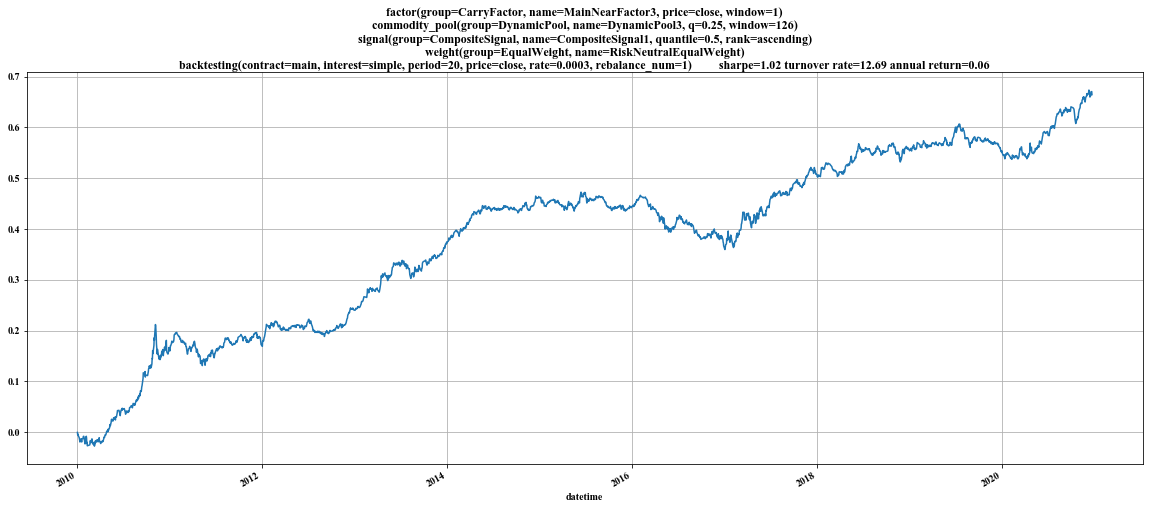

In [48]:
self.plot()

### metrics: all, industry, symbol

In [49]:
self.backtest_result

{'metrics': {'symbol':                    long_rate  short_rate  participate_rate  turnover_rate  \
  underlying_symbol                                                           
  A                   0.205452    0.794548          0.475766       0.874823   
  AG                  0.051612    0.948388          0.108147       0.130279   
  AL                  0.385340    0.614660          0.247478       0.251566   
  AP                  0.421086    0.578914          0.152093       0.101897   
  AU                  0.250878    0.749122          0.090876       0.161392   
  ...                      ...         ...               ...            ...   
  WR                  0.000000    0.000000          0.000000       0.000000   
  WT                  0.000000    0.000000          0.000000       0.000000   
  Y                   0.107412    0.892588          0.371743       0.360967   
  ZC                  0.587785    0.412215          0.402550       0.343878   
  ZN                  0.435011 

In [51]:
self.backtest_result['metrics']['all']

long_rate                0.360692
short_rate               0.639308
participate_rate         1.000000
turnover_rate           12.693711
long_turnover_rate       8.712588
short_turnover_rate      8.552482
win_rate                 0.619453
long_win_rate            0.547503
short_win_rate           0.556725
total_return             0.670681
long_total_return        0.448390
short_total_return       0.266345
annual_return            0.063371
long_annual_return       0.042368
short_annual_return      0.025167
gain_loss_rate           2.204414
long_gain_loss_rate      1.504403
short_gain_loss_rate     1.291641
sharpe                   1.024783
max_drawdown             0.098226
dtype: float64

In [52]:
self.backtest_result['metrics']['industry']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
industry_name,,,,,,,,,,,,,,,,,,,,
农产品,0.357916,0.642084,0.578296,0.609715,0.372526,0.422668,0.494621,0.461309,0.489333,0.010315,-0.008323,0.020010,0.000975,-0.000786,0.001891,1.108982,0.874048,1.283059,0.084098,0.044766
化工,0.420925,0.579075,0.984609,2.488066,1.681051,1.644859,0.536463,0.514516,0.559210,0.028586,-0.034805,0.074628,0.002701,-0.003289,0.007051,1.090304,0.901728,1.241219,0.089751,0.080333
国债,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
建材,0.549868,0.450132,0.755185,0.957273,0.657854,0.603344,0.586128,0.554997,0.585091,0.081066,0.045579,0.036340,0.007660,0.004307,0.003434,1.674183,1.580286,1.540043,0.535205,0.035256
有色,0.507136,0.492864,0.546013,0.859153,0.631592,0.626353,0.595094,0.607920,0.556705,0.081220,0.049020,0.035413,0.007674,0.004632,0.003346,2.034739,2.371673,1.667233,0.546990,0.026437
未知,0.222500,0.777500,0.026661,0.022919,0.010688,0.016437,0.417500,0.075000,0.479167,-0.002235,-0.002058,0.000059,-0.000211,-0.000194,0.000006,inf,inf,inf,-0.076438,0.007533
油脂,0.434157,0.565843,0.979337,2.702279,1.815602,1.920238,0.552686,0.539306,0.517791,0.071557,0.057568,0.022468,0.006761,0.005439,0.002123,1.398895,1.392902,1.138019,0.261320,0.065459
焦煤钢矿,0.674087,0.325913,0.894484,2.183890,1.613405,1.242182,0.602801,0.588471,0.550651,0.201130,0.197676,0.012721,0.019004,0.018678,0.001202,1.595487,1.612018,0.999827,0.511272,0.086062
股指,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000


In [54]:
self.backtest_result['metrics']['symbol']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
underlying_symbol,,,,,,,,,,,,,,,,,,,,
A,0.205452,0.794548,0.475766,0.874823,0.562037,0.700479,0.510794,0.575897,0.494908,0.012336,0.015466,-0.002861,0.001166,0.001461,-0.000270,1.140158,1.910561,1.019466,0.081427,0.034950
AG,0.051612,0.948388,0.108147,0.130279,0.066984,0.126212,0.191970,0.006724,0.190180,0.015728,-0.002789,0.017966,0.001486,-0.000264,0.001698,3.896075,inf,4.297796,0.358733,0.013801
AL,0.385340,0.614660,0.247478,0.251566,0.184095,0.185822,0.605885,0.558613,0.642150,0.023247,0.013746,0.009417,0.002197,0.001299,0.000890,2.121338,2.874176,2.007125,0.340582,0.019220
AP,0.421086,0.578914,0.152093,0.101897,0.063999,0.074140,0.124863,0.053708,0.082484,0.034004,0.016581,0.017830,0.003213,0.001567,0.001685,3.015010,2.963969,3.468037,1.017030,0.012970
AU,0.250878,0.749122,0.090876,0.161392,0.113359,0.124746,0.543981,0.376667,0.633583,0.000729,-0.004947,0.004889,0.000069,-0.000467,0.000462,1.333306,inf,inf,0.023492,0.016840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
Y,0.107412,0.892588,0.371743,0.360967,0.184667,0.333244,0.589804,0.729643,0.575936,0.017832,0.007400,0.013214,0.001685,0.000699,0.001249,1.488046,inf,1.416097,0.283872,0.019505


## what about smoothing this factor

In [55]:
self = LongShortPeriodBacktesting(rate=0.0003, period=20, interest='simple', contract='main', price='close', rebalance_num=1)
self.set_factor(group='CarryFactor', name='MainNearFactor3', window=60)
self.set_commodity_pool(group='DynamicPool', name='DynamicPool3')
self.set_signal(group='CompositeSignal', name='CompositeSignal1', rank='ascending')
self.set_weight(group='EqualWeight', name='RiskNeutralEqualWeight')
self.prepare_weights()
self.run_backtesting()

100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1046.20it/s]


{'symbol':                    long_rate  short_rate  participate_rate  turnover_rate  \
 underlying_symbol                                                           
 A                   0.159649    0.840351          0.469448       0.419194   
 AG                  0.000000    1.000000          0.125968       0.093336   
 AL                  0.380588    0.619412          0.293609       0.190922   
 AP                  0.434160    0.565840          0.197590       0.056755   
 AU                  0.405833    0.594167          0.031871       0.068713   
 ...                      ...         ...               ...            ...   
 WR                  0.000000    0.000000          0.000000       0.000000   
 WT                  0.000000    0.000000          0.000000       0.000000   
 Y                   0.062973    0.937027          0.409853       0.190976   
 ZC                  0.696180    0.303820          0.353207       0.166057   
 ZN                  0.382062    0.617938          0.1

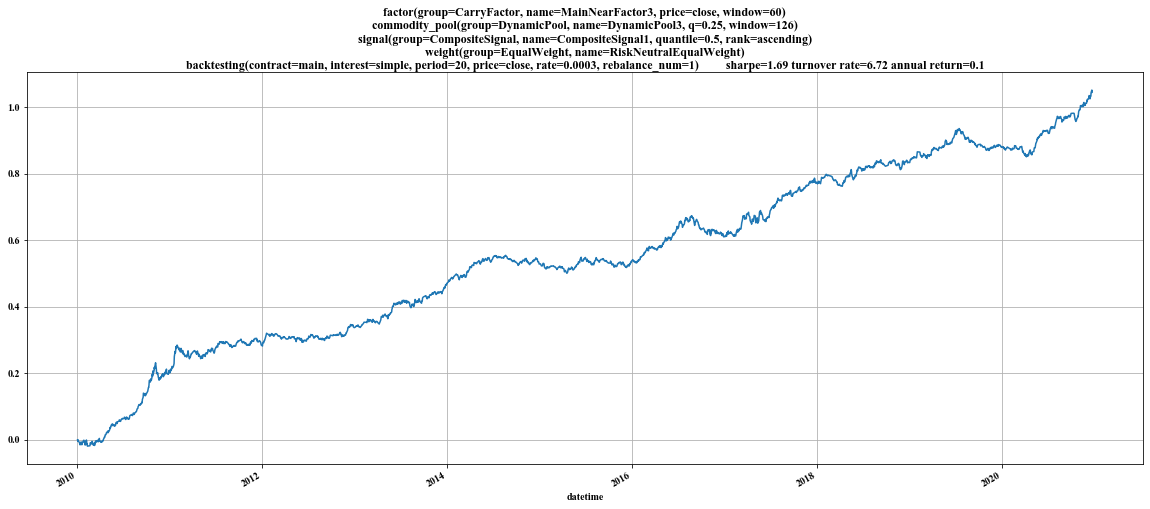

In [56]:
self.plot()

In [57]:
self.backtest_result['metrics']['all']

long_rate               0.314120
short_rate              0.685880
participate_rate        1.000000
turnover_rate           6.720646
long_turnover_rate      4.779096
short_turnover_rate     4.540282
win_rate                0.667692
long_win_rate           0.574075
short_win_rate          0.575410
total_return            1.049235
long_total_return       0.655731
short_total_return      0.396548
annual_return           0.099140
long_annual_return      0.061959
short_annual_return     0.037469
gain_loss_rate          3.433297
long_gain_loss_rate     1.763338
short_gain_loss_rate    1.534951
sharpe                  1.686814
max_drawdown            0.050940
dtype: float64

In [58]:
self.backtest_result['metrics']['industry']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
industry_name,,,,,,,,,,,,,,,,,,,,
农产品,0.299224,0.700776,0.617571,0.320980,0.198137,0.238103,0.540735,0.465015,0.559423,0.022975,-0.017273,0.040120,0.002171,-0.001632,0.003791,1.215195,0.725230,1.596986,0.206424,0.030383
化工,0.431370,0.568630,0.998507,1.304316,0.945096,0.833201,0.560108,0.530404,0.552006,0.085149,0.013504,0.071989,0.008046,0.001276,0.006802,1.234208,1.045771,1.250621,0.263228,0.069590
国债,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
建材,0.539198,0.460802,0.765989,0.536870,0.384806,0.334089,0.605440,0.553529,0.638582,0.106844,0.052159,0.053649,0.010095,0.004928,0.005069,2.054067,1.690640,2.084708,0.756118,0.029683
有色,0.527557,0.472443,0.566976,0.579774,0.432428,0.412581,0.589464,0.533393,0.588163,0.063220,0.020002,0.043083,0.005974,0.001890,0.004071,1.696499,1.432102,1.738410,0.468665,0.028054
未知,0.000000,1.000000,0.023614,0.010566,0.003910,0.010566,0.387500,0.000000,0.387500,-0.003679,0.000139,-0.003679,-0.000348,0.000013,-0.000348,0.375661,0.000000,0.375661,-0.214064,0.007725
油脂,0.426975,0.573025,0.984275,1.369492,0.932987,0.981447,0.561164,0.547781,0.523007,0.104468,0.074137,0.030499,0.009871,0.007005,0.002882,1.534144,1.549196,1.168837,0.400899,0.068383
焦煤钢矿,0.661006,0.338994,0.889768,1.093261,0.907879,0.583673,0.642921,0.597921,0.585684,0.330279,0.271804,0.062740,0.031207,0.025682,0.005928,2.029670,1.890500,1.289972,0.839980,0.087762
股指,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000


In [59]:
self.backtest_result['metrics']['symbol']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
underlying_symbol,,,,,,,,,,,,,,,,,,,,
A,0.159649,0.840351,0.469448,0.419194,0.247004,0.343819,0.515083,0.525922,0.512613,0.010781,0.009679,0.001343,0.001019,0.000915,0.000127,1.111569,1.878049,1.022932,0.074797,0.033589
AG,0.000000,1.000000,0.125968,0.093336,0.043407,0.093336,0.267421,0.000000,0.267421,0.031547,0.000336,0.031547,0.002981,0.000032,0.002981,8.732604,0.000000,8.732604,0.731352,0.006663
AL,0.380588,0.619412,0.293609,0.190922,0.139967,0.134483,0.616113,0.526545,0.672775,0.025944,0.010178,0.015206,0.002451,0.000962,0.001437,1.874740,1.666525,2.379398,0.386335,0.013870
AP,0.434160,0.565840,0.197590,0.056755,0.035401,0.039487,0.129936,0.047975,0.096663,0.016656,-0.003190,0.020119,0.001574,-0.000301,0.001901,1.676509,0.868286,3.909812,0.545205,0.021861
AU,0.405833,0.594167,0.031871,0.068713,0.056527,0.041805,0.649167,0.633333,0.760000,0.001173,-0.002461,0.003876,0.000111,-0.000232,0.000366,inf,inf,inf,0.018297,0.014800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
Y,0.062973,0.937027,0.409853,0.190976,0.087827,0.183788,0.592970,0.666667,0.588142,0.013791,0.002967,0.010835,0.001303,0.000280,0.001024,1.323354,inf,1.261598,0.209193,0.024630


### GroupBacktesting

In [61]:
from backtesting.group_backtesting import GroupBacktesting

In [62]:
self = GroupBacktesting(rate=0.0003, period=20, interest='simple', contract='main', price='close', rebalance_num=1, group_num=5)
self.set_factor(group='CarryFactor', name='MainNearFactor3', window=60)
self.set_commodity_pool(group='DynamicPool', name='DynamicPool3')
self.set_signal(group='GroupSignal', name='GroupLongSignal1', rank='ascending')
self.set_weight(group='GroupWeight', name='GroupEqualWeight')
self.prepare_weights()
self.run_backtesting()

100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1027.26it/s]


100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1030.02it/s]


<Figure size 1440x576 with 0 Axes>

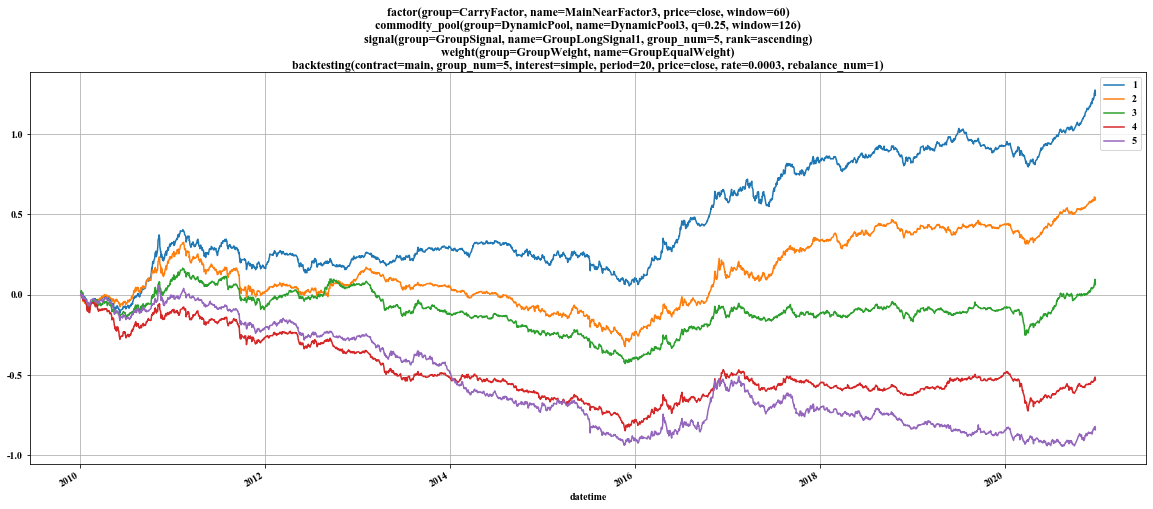

In [63]:
self.output_backtest_result()

### factor decay

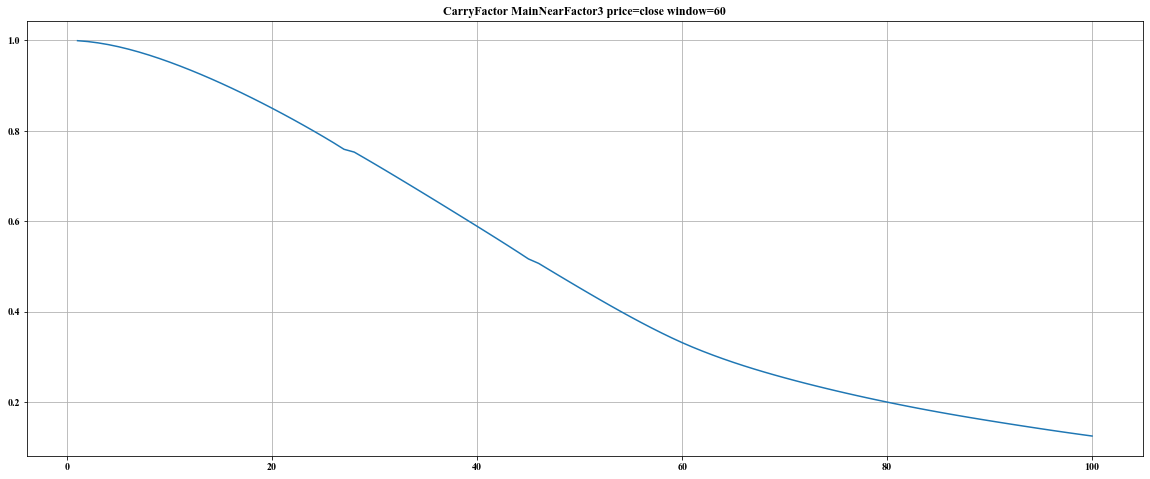

In [64]:
from factor_test.base import BaseFactorTest
self = BaseFactorTest()
self.set_factor(group='CarryFactor', name='MainNearFactor3', window=60)
self.get_factor_autocorrelation()

One important pattern is that the auotocorrelation curve is concave when the lag is smaller than 60 but convex when the lag is larger than 60, which is exactly the smoothing window.

## slope Factor

In [65]:
self = LongShortPeriodBacktesting(rate=0.0003, period=20, interest='simple', contract='main', price='close', rebalance_num=1)
self.set_factor(group='CarryFactor', name='SlopeFactor1', window=60)
self.set_commodity_pool(group='DynamicPool', name='DynamicPool3')
self.set_signal(group='CompositeSignal', name='CompositeSignal1', rank='ascending')
self.set_weight(group='EqualWeight', name='RiskNeutralEqualWeight')
self.prepare_weights()
self.run_backtesting()

100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1016.78it/s]


{'symbol':                    long_rate  short_rate  participate_rate  turnover_rate  \
 underlying_symbol                                                           
 A                   0.196877    0.803123          0.427820       0.420224   
 AG                  0.000000    1.000000          0.317961       0.074368   
 AL                  0.050733    0.949267          0.254983       0.162664   
 AP                  0.574063    0.425937          0.252696       0.041463   
 AU                  0.000000    0.800000          0.007499       0.008654   
 ...                      ...         ...               ...            ...   
 WR                  0.000000    0.000000          0.000000       0.000000   
 WT                  0.000000    0.000000          0.000000       0.000000   
 Y                   0.045630    0.954370          0.418070       0.138465   
 ZC                  0.647120    0.352880          0.362190       0.096526   
 ZN                  0.303015    0.696985          0.3

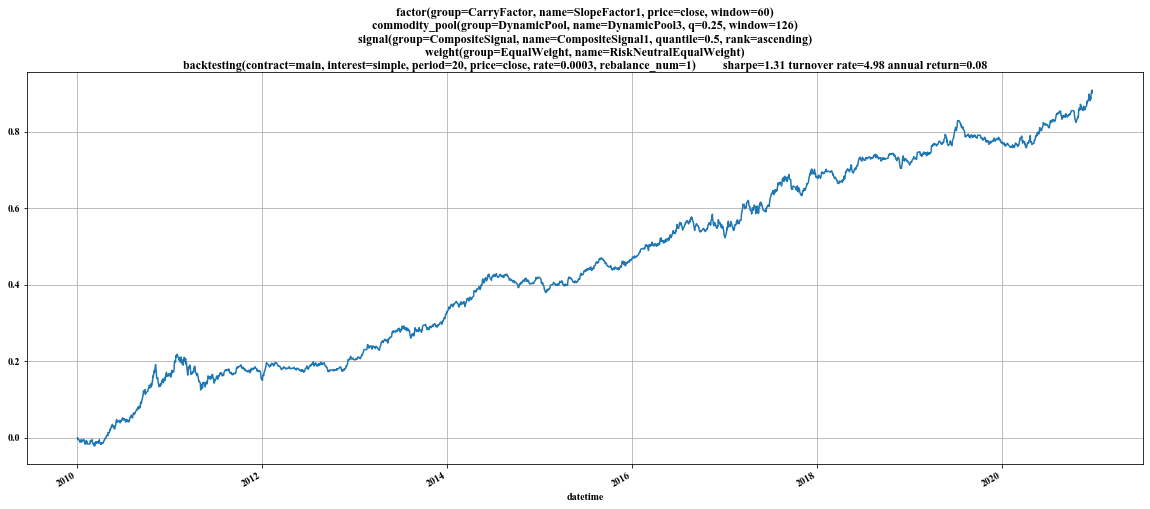

In [66]:
self.plot()

In [67]:
self.backtest_result['metrics']['all']

long_rate               0.393871
short_rate              0.606129
participate_rate        1.000000
turnover_rate           4.975691
long_turnover_rate      3.634026
short_turnover_rate     3.197300
win_rate                0.664634
long_win_rate           0.551549
short_win_rate          0.560770
total_return            0.895511
long_total_return       0.513481
short_total_return      0.381789
annual_return           0.084615
long_annual_return      0.048518
short_annual_return     0.036075
gain_loss_rate          2.754412
long_gain_loss_rate     1.551467
short_gain_loss_rate    1.532186
sharpe                  1.312040
max_drawdown            0.079163
dtype: float64

In [68]:
self.backtest_result['metrics']['industry']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
industry_name,,,,,,,,,,,,,,,,,,,,
农产品,0.420914,0.579086,0.611197,0.293995,0.187465,0.210995,0.512059,0.476092,0.537026,0.012486,-0.003509,0.015167,0.001180,-0.000332,0.001433,1.104530,0.960424,1.237991,0.105315,0.036267
化工,0.432963,0.567037,0.986881,0.875972,0.627625,0.530781,0.576181,0.529572,0.575616,0.132351,0.052318,0.077857,0.012506,0.004943,0.007357,1.364339,1.185622,1.262705,0.397494,0.061040
国债,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
建材,0.514746,0.485254,0.739058,0.324140,0.261839,0.193557,0.647282,0.608384,0.681771,0.138603,0.061833,0.077116,0.013096,0.005842,0.007287,3.021070,2.359300,4.170256,1.128098,0.017763
有色,0.187080,0.812920,0.650154,0.459467,0.289396,0.379691,0.503788,0.470530,0.512932,0.020832,-0.013351,0.033896,0.001968,-0.001262,0.003203,1.160740,0.633318,1.312573,0.150521,0.037229
未知,0.480000,0.520000,0.034870,0.020532,0.014511,0.015412,0.400000,0.390000,0.425000,-0.005545,-0.001231,-0.003910,-0.000524,-0.000116,-0.000369,0.592577,0.795323,0.379497,-0.172595,0.014334
油脂,0.432522,0.567478,0.987602,1.085817,0.783875,0.726097,0.513637,0.470033,0.517404,0.039015,0.009056,0.030288,0.003686,0.000856,0.002862,1.210504,1.148298,1.143119,0.146427,0.069648
焦煤钢矿,0.630355,0.369645,0.874776,0.672749,0.586098,0.315426,0.628770,0.601704,0.588900,0.352245,0.283036,0.070396,0.033283,0.026744,0.006652,2.012946,1.902307,1.625533,0.822161,0.061360
股指,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000


In [69]:
self.backtest_result['metrics']['symbol']

,long_rate,short_rate,participate_rate,turnover_rate,long_turnover_rate,short_turnover_rate,win_rate,long_win_rate,short_win_rate,total_return,long_total_return,short_total_return,annual_return,long_annual_return,short_annual_return,gain_loss_rate,long_gain_loss_rate,short_gain_loss_rate,sharpe,max_drawdown
underlying_symbol,,,,,,,,,,,,,,,,,,,,
A,0.196877,0.803123,0.427820,0.420224,0.286846,0.312888,0.485718,0.481598,0.486550,-0.011147,-0.004807,-0.005974,-0.001053,-0.000454,-0.000564,0.923778,0.878720,0.940834,-0.074441,0.053970
AG,0.000000,1.000000,0.317961,0.074368,0.027862,0.074368,0.358191,0.000000,0.358191,0.025420,-0.000013,0.025420,0.002402,-0.000001,0.002402,1.755944,0.000000,1.755944,0.412442,0.017724
AL,0.050733,0.949267,0.254983,0.162664,0.097875,0.139006,0.504762,0.187500,0.516599,0.003174,-0.005469,0.008425,0.000300,-0.000517,0.000796,1.174629,2.237191,1.458149,0.063609,0.016157
AP,0.574063,0.425937,0.252696,0.041463,0.026491,0.026831,0.153578,0.092862,0.083191,0.019892,0.011352,0.008438,0.001880,0.001073,0.000797,1.498013,1.459389,1.615338,0.575731,0.018253
AU,0.000000,0.800000,0.007499,0.008654,0.004232,0.008654,0.600000,0.000000,0.600000,-0.000783,-0.000071,-0.000783,-0.000074,-0.000007,-0.000074,inf,0.000000,inf,NaN,0.002412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
WT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
Y,0.045630,0.954370,0.418070,0.138465,0.063474,0.129726,0.588531,0.816667,0.578714,0.010055,0.002377,0.007547,0.000950,0.000225,0.000713,1.269539,inf,1.207999,0.168158,0.019971


### GroupBacktesting

In [70]:
self = GroupBacktesting(rate=0.0003, period=20, interest='simple', contract='main', price='close', rebalance_num=1, group_num=5)
self.set_factor(group='CarryFactor', name='SlopeFactor1', window=60)
self.set_commodity_pool(group='DynamicPool', name='DynamicPool3')
self.set_signal(group='GroupSignal', name='GroupLongSignal1', rank='ascending')
self.set_weight(group='GroupWeight', name='GroupEqualWeight')
self.prepare_weights()
self.run_backtesting()

100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1007.19it/s]


100%|███████████████████████████████████████████████| 2667/2667 [00:02<00:00, 1037.27it/s]


<Figure size 1440x576 with 0 Axes>

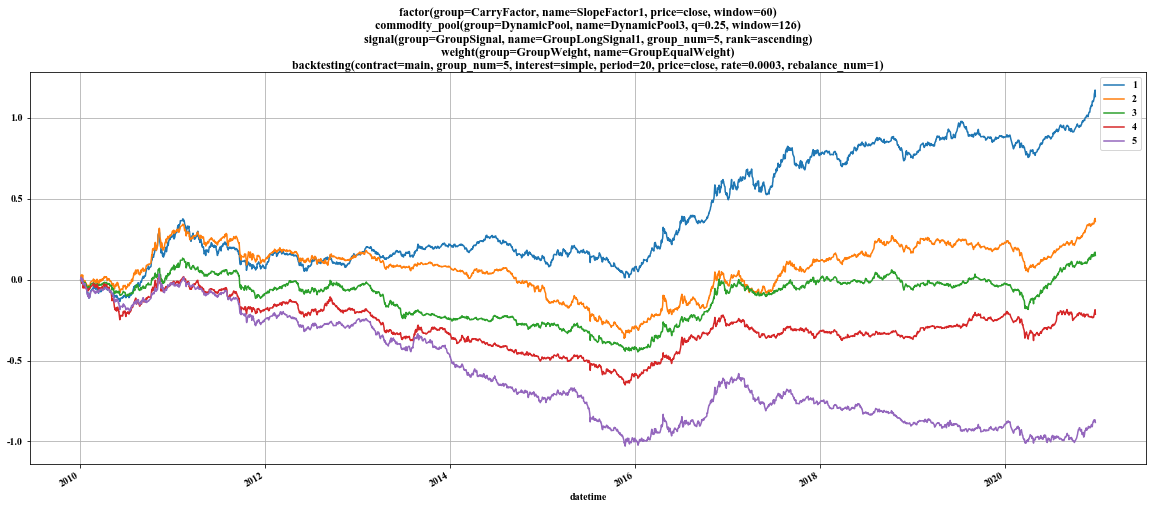

In [71]:
self.output_backtest_result()